In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import random
import math

torch.manual_seed(42)
random.seed(42)

In [2]:
def tokenize(string, max_len=202):
    base = [1] + [3 if char == 'a' else 4 for char in string] + [2]
    return base + [0] * (max_len - len(base))

# Dataset generation
def generate_positive_samples(n_min, n_max):
    n_max = n_max if n_max % 2 == 0 else n_max - 1
    n_max = int(n_max/2)
    return [("a" * n + "b" * n, 1) for n in range(n_min, n_max + 1)]

def generate_negative_samples(length_min, length_max, n_samples):
    samples = []
    while len(samples) < n_samples:
        length = random.randint(length_min, length_max)
        string = "".join(random.choices("ab", k=length))
        mid = string.find("b")
        if mid != -1 and string[:mid] == "a" * mid and string[mid:] == "b" * (length - mid):
            continue
        samples.append((string, 0))
    return samples

# Dataset and DataLoader
class StringDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        string, label = self.data[idx]
        return torch.tensor(tokenize(string)), label

# def collate_fn(batch):
#     strings, labels = zip(*batch)
#     max_len = 100
#     padded = [torch.cat([s, torch.zeros(max_len - len(s), dtype=torch.long)]) for s in strings]
#     return torch.stack(padded), torch.tensor(labels)

In [3]:
positive_samples = generate_positive_samples(1, 100)  # Positive samples up to n=50
negative_samples = generate_negative_samples(2, 100, len(positive_samples))  # Equal number of negative samples
dataset = positive_samples + negative_samples

train_loader = DataLoader(StringDataset(dataset), batch_size=16, shuffle=True)
train_loader_positive = DataLoader(StringDataset(positive_samples), batch_size=16, shuffle=True)

positive_test_samples = generate_positive_samples(20, 200)
negative_test_samples = generate_negative_samples(20, 200, len(positive_test_samples))
test_dataset = positive_test_samples + negative_test_samples

test_loader = DataLoader(StringDataset(test_dataset), batch_size=16, shuffle=False)
test_loader_positive = DataLoader(StringDataset(positive_test_samples), batch_size=16, shuffle=False)
test_loader_negative = DataLoader(StringDataset(negative_test_samples), batch_size=16, shuffle=False)
print("Train samples:", len(dataset))
print("Test samples:", len(test_dataset))

Train samples: 100
Test samples: 162


In [4]:
import torch
import torch.nn as nn
import math

class SmallTransformer(nn.Module):
    def __init__(self, vocab_size=5, embed_dim=64, num_heads=4, num_layers=1, hidden_dim=128, dropout=0.3):
        super(SmallTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        # Fully connected output layer
        self.fc = nn.Linear(embed_dim, 2)

    def generate_positional_encoding(self, seq_len, embed_dim, device):
        position = torch.arange(seq_len, dtype=torch.float, device=device).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2, device=device).float() * (-math.log(10000.0) / embed_dim))
        pos_enc = torch.zeros(seq_len, embed_dim, device=device)
        pos_enc[:, 0::2] = torch.sin(position * div_term)
        pos_enc[:, 1::2] = torch.cos(position * div_term)
        return pos_enc.unsqueeze(0)  # Shape: (1, seq_len, embed_dim)

    def forward(self, x, return_internal=False):
        device = x.device
        seq_len = x.size(1)
        embed_dim = self.embedding.embedding_dim

        # Embed input and add positional encoding
        x = self.embedding(x)  # Shape: (batch_size, seq_len, embed_dim)
        positional_encoding = self.generate_positional_encoding(seq_len, embed_dim, device)
        x = x + positional_encoding  # Shape: (batch_size, seq_len, embed_dim)

        # Transformer encoder expects input of shape (seq_len, batch_size, embed_dim)
        x = x.permute(1, 0, 2)  # Shape: (seq_len, batch_size, embed_dim)
        internal_representation = self.transformer_encoder(x)  # Shape: (seq_len, batch_size, embed_dim)
        
        # Extract [CLS]-like token from the first position
        cls_rep = internal_representation[0]  # Shape: (batch_size, embed_dim)

        # Classification output
        output = self.fc(cls_rep)  # Shape: (batch_size, 2)

        if return_internal:
            return output, internal_representation.permute(1, 0, 2)  # Shape: (batch_size, seq_len, embed_dim)
        else:
            return output

In [ ]:
device = 'cuda'

model = SmallTransformer().to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
optimizer = optim.SGD(model.parameters(), lr=3e-4, momentum=0.9)

def evaluate_model(model, data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get the model output and internal representation
            outputs = model(inputs)  # We're only interested in the output for evaluation
            
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    print(f"Accuracy: {correct / total:.2%}")

loss_hist = []
def train_model(model, train_loader, epochs=100):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get the model output and internal representation
            outputs = model(inputs)  # We're only interested in the output for loss calculation
            
            # Calculate the loss
            loss = criterion(outputs, labels)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            loss_hist.append(loss.item())
            
            # Calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
        
        # scheduler.step()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}, Accuracy: {correct / total:.2%}")
        
        if (epoch+1) % 100 == 0:
            evaluate_model(model, test_loader)

EPOCHS = 250
train_model(model, train_loader, epochs = EPOCHS)

/data2/abhipsa/miniconda3/envs/captioning/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/data2/abhipsa/miniconda3/envs/captioning/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/250, Loss: 0.7448, Accuracy: 51.00%
Epoch 2/250, Loss: 0.7190, Accuracy: 50.00%
Epoch 3/250, Loss: 0.7182, Accuracy: 54.00%
Epoch 4/250, Loss: 0.6899, Accuracy: 56.00%
Epoch 5/250, Loss: 0.7170, Accuracy: 50.00%
Epoch 6/250, Loss: 0.7011, Accuracy: 51.00%
Epoch 7/250, Loss: 0.6934, Accuracy: 51.00%
Epoch 8/250, Loss: 0.6735, Accuracy: 59.00%
Epoch 9/250, Loss: 0.7016, Accuracy: 52.00%
Epoch 10/250, Loss: 0.6989, Accuracy: 51.00%
Epoch 11/250, Loss: 0.6976, Accuracy: 48.00%
Epoch 12/250, Loss: 0.6868, Accuracy: 55.00%
Epoch 13/250, Loss: 0.7103, Accuracy: 42.00%
Epoch 14/250, Loss: 0.6727, Accuracy: 60.00%
Epoch 15/250, Loss: 0.6737, Accuracy: 59.00%
Epoch 16/250, Loss: 0.6585, Accuracy: 68.00%
Epoch 17/250, Loss: 0.6333, Accuracy: 67.00%
Epoch 18/250, Loss: 0.6415, Accuracy: 69.00%
Epoch 19/250, Loss: 0.5657, Accuracy: 79.00%
Epoch 20/250, Loss: 0.5581, Accuracy: 76.00%
Epoch 21/250, Loss: 0.4764, Accuracy: 81.00%
Epoch 22/250, Loss: 0.4302, Accuracy: 86.00%
Epoch 23/250, Loss:

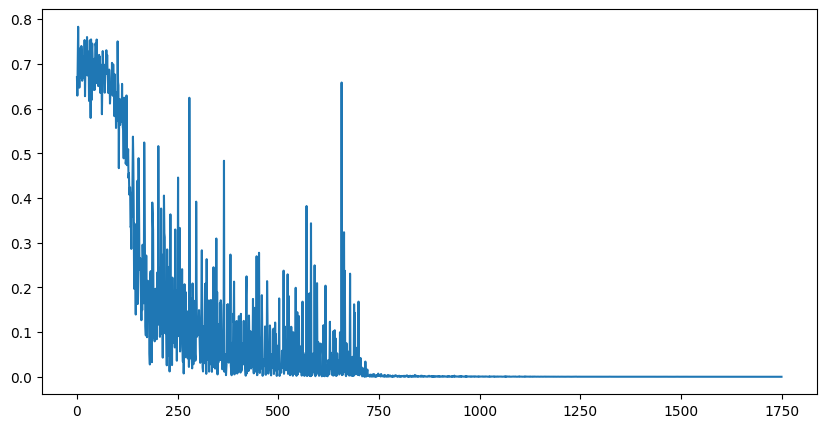

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

plt.plot(loss_hist)

In [6]:
evaluate_model(model, test_loader)
evaluate_model(model, test_loader_positive)
evaluate_model(model, test_loader_negative)
evaluate_model(model, train_loader_positive)
evaluate_model(model, train_loader)

Accuracy: 80.86%
Accuracy: 61.73%
Accuracy: 100.00%
Accuracy: 100.00%
Accuracy: 100.00%


Input sequence: tensor([[1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2]],
       device='cuda:0')
Prediction: 1


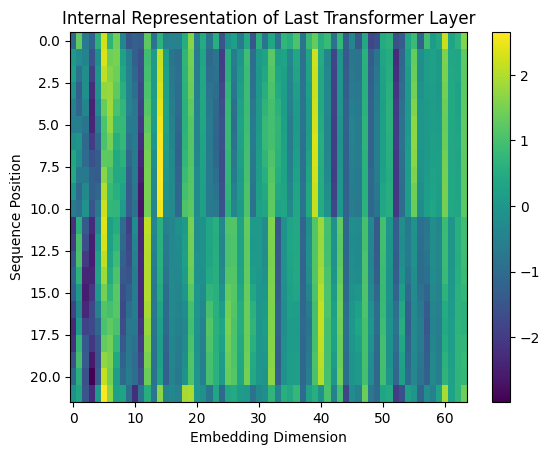

In [20]:
import matplotlib.pyplot as plt
input_sequence = "a" * 10 + "b" * 10
input_sequence = torch.tensor(tokenize(input_sequence), dtype=torch.long).unsqueeze(0).to(device)
output, internal_rep = model(input_sequence, return_internal=True)

print("Input sequence:", input_sequence)
print("Prediction:", torch.argmax(output, dim=1).item())

# Visualize activations of the last layer
plt.imshow(internal_rep.squeeze().cpu().detach().numpy(), aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Internal Representation of Last Transformer Layer")
plt.xlabel("Embedding Dimension")
plt.ylabel("Sequence Position")
plt.show()

In [18]:
class StackProbingClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(StackProbingClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)  # Binary classification: valid (1) or invalid (0)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

# Probing classifier training function
def train_stack_probe_classifier(model, train_loader, probing_classifier, epochs=10):
    model.eval()  # Set the transformer model to evaluation mode
    probing_classifier.train()  # Train the probing classifier
    
    criterion = nn.BCELoss()  # Binary Cross-Entropy loss
    optimizer = optim.Adam(probing_classifier.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            
            # Get internal representations from the transformer model
            _, internal_rep = model(inputs, return_internal=True)
            
            # Use the internal representation of the last layer for probing
            # Extract the internal state at the last token
            last_token_rep = internal_rep[:, -1, :]  # Last token's internal state
            
            # Pass through the probing classifier
            outputs = probing_classifier(last_token_rep).squeeze(1)
            
            # Compute the loss
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            # Calculate accuracy (for the last token)
            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}, Accuracy: {correct / total:.2%}")


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluation function for the probing classifier
def evaluate_stack_probe_classifier(model, data_loader, probing_classifier):
    model.eval()  # Set the transformer model to evaluation mode
    probing_classifier.eval()  # Set the probing classifier to evaluation mode
    
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            
            # Get internal representations from the transformer model
            _, internal_rep = model(inputs, return_internal=True)
            
            # Use the internal representation of the last token for probing
            last_token_rep = internal_rep[:, -1, :]  # Last token's internal state
            
            # Get the probe classifier's prediction for the last token
            outputs = probing_classifier(last_token_rep).squeeze(1)
            
            # Collect predictions and labels
            predictions = (outputs > 0.5).float()
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    
    # Print evaluation metrics
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Precision: {precision:.2%}")
    print(f"Recall: {recall:.2%}")
    print(f"F1-Score: {f1:.2%}")
    
    return accuracy, precision, recall, f1


In [23]:
class ProbingClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(ProbingClassifier, self).__init__()
        # A simple feedforward network to probe the transformer internal representations
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)  # Output a single value (binary classification)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)  # Apply sigmoid to get probabilities
        return x


In [24]:
# Define the probing classifier
input_dim = 64  # Embedding dimension of the transformer
probing_classifier = ProbingClassifier(input_dim).to(device)

# Define loss function and optimizer
probing_criterion = nn.BCELoss()
probing_optimizer = optim.Adam(probing_classifier.parameters(), lr=0.001)

# Training loop for the probing classifier
def train_probing_classifier(probing_classifier, model, train_loader, epochs=10):
    probing_classifier.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            
            # Get internal representations from the transformer model
            _, internal_rep = model(inputs, return_internal=True)
            
            # Use the internal representation of the last token for probing
            last_token_rep = internal_rep[:, -1, :]
            
            # Forward pass through the probing classifier
            outputs = probing_classifier(last_token_rep).squeeze(1)
            
            # Compute the loss
            loss = probing_criterion(outputs, labels)
            probing_optimizer.zero_grad()
            loss.backward()
            probing_optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")


In [25]:
# Evaluate the probing classifier on the test dataset

evaluate_stack_probe_classifier(model, test_loader, probing_classifier)


Accuracy: 50.00%
Precision: 0.00%
Recall: 0.00%
F1-Score: 0.00%


/Users/utkarsh/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.5, 0.0, 0.0, 0.0)